In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm.auto import tqdm
import csv

In [2]:
# import tensorflow as tf

# # You'll generate plots of attention in order to see which parts of an image
# # your model focuses on during captioning
# import matplotlib.pyplot as plt

# import collections
# import random
# import numpy as np
# import os
# import time
# import json
# from PIL import Image


# #Download caption annotation files
# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                            cache_subdir=os.path.abspath('.'),
#                                            origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                            extract=True)
#   annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
#   os.remove(annotation_zip)

# # Download image files
# image_folder = '/train2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('train2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin='http://images.cocodataset.org/zips/train2014.zip',
#                                       extract=True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder



Inside annotations
dict_keys(['info', 'images', 'licenses', 'annotations'])
dict_keys(['info', 'images', 'licenses', 'annotations'])


Annotations information
{'description': 'COCO 2014 Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2014, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}
{'description': 'COCO 2014 Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2014, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}


Size of dataset using
Number of training images is 82783
Number of captions in training set414113
Number of validation set images40504
Number of vaptions in validation set202654


Details of first image in training set
{'file_path': '../input/ms-coco-dataset/train2014/train2014/COCO_train2014_000000057870.jpg', 'id': 57870, 'captions': ['A restaurant has modern wooden tables and chairs.', 'A long restaurant table with rattan rounded back chairs.', 'a long table with a plant on top of it surrounded wit

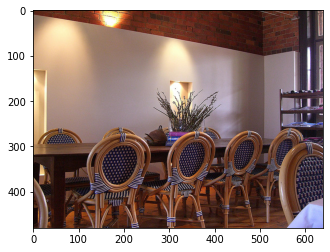

In [3]:
'''Visualize dataset'''

import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#Loading captions
train = json.load(open('../input/ms-coco-dataset/captions/annotations/captions_train2014.json', 'r'))
val = json.load(open('../input/ms-coco-dataset/captions/annotations/captions_val2014.json', 'r'))

#Annotations keys
print("\nInside annotations")
print(train.keys())
print(val.keys())

#Annotations info
print("\n\nAnnotations information")
print(train['info'])
print(val['info'])

#Dataset size
print("\n\nSize of dataset using")
print("Number of training images is "+str(len(train['images'])))
print("Number of captions in training set"+str(len(train['annotations'])))
print("Number of validation set images"+str(len(val['images'])))
print("Number of vaptions in validation set"+str(len(val['annotations'])))

# combine all images and annotations together
imgs = train['images']
annots = train['annotations']

# Group annotations by image
itoa = {}
for a in annots:
    imgid = a['image_id']
    if imgid not in itoa:
        itoa[imgid] = []
    itoa[imgid].append(a)

# Create the json blob for an image and its captions
out = []
for i, img in enumerate(imgs):
    imgid = img['id']
    
    loc = 'train' if 'train' in img['file_name'] else 'val'
    loc = '../input/ms-coco-dataset/train2014/train2014'
    jimg = {}
    jimg['file_path'] = os.path.join(loc, img['file_name'])
    jimg['id'] = imgid
    jimg['captions'] = [a['caption'] for a in itoa[imgid]]
    
    out.append(jimg)
    
#Dumping in json format for better understanding
json.dump(out, open('coco_raw.json', 'w'))


#Display first image and it's captions
print("\n\nDetails of first image in training set")
first_img = out[0]
print(first_img)

image = mpimg.imread(first_img['file_path'])
print(image.shape)
plt.imshow(image)


In [4]:
'''Shuffling images and captions'''

PATH = '../input/ms-coco-dataset/train2014/train2014/'
all_captions = []
all_img_name_vector = []
for a in annots:
    caption = '<start> ' + a['caption'] + ' <end>'
    image_id = a['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)
    
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]


In [5]:
len(train_captions), len(all_captions)

(30000, 414113)

In [6]:
'''Preprocess images for inceptionv3'''
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# Get unique images
encode_train = sorted(set(img_name_vector))

#Feeding image dataset
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

#os.remove('../working/Image')
os.mkdir("Image")
OUTPUT_PATH = "../working/Image/"
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    file_name = p.numpy().decode("utf-8").split('/')[-1]
    np.save(OUTPUT_PATH + file_name, bf.numpy())


2022-07-12 11:17:56.436922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 11:17:56.565421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 11:17:56.566261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 11:17:56.567415: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


2022-07-12 11:18:01.719051: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  0%|          | 0/811 [00:00<?, ?it/s]

2022-07-12 11:18:03.274696: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [7]:
'''Preprocess captions'''

#Find max length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

#Setting word index of pad
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print(max_length)

49


In [8]:
'''Split train-test and create tf dataset'''

# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.0333,
                                                                    random_state=0)

#Other parameters
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

# Load the numpy files
def map_func(img_name, cap):
  filename = OUTPUT_PATH + img_name.decode('utf-8').split('/')[-1] + ".npy"
  img_tensor = np.load(filename)
  return img_tensor, cap

#Creating tensor dataset
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [9]:
'''MODEL'''

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [10]:
'''Checkpoint manager'''

checkpoint_path = "../working/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [11]:
#Keeping loss plot in separate cell as train step is called many times will reset loss plot
loss_plot = []

In [12]:
'''Training'''

#Tensorflow train step function
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss



In [13]:
EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0638
Epoch 1 Batch 100 Loss 1.1073
Epoch 1 Batch 200 Loss 0.9815
Epoch 1 Batch 300 Loss 0.8813
Epoch 1 Batch 400 Loss 0.9291
Epoch 1 Loss 1.003398
Time taken for 1 epoch 197.14683628082275 sec

Epoch 2 Batch 0 Loss 0.7982
Epoch 2 Batch 100 Loss 0.8128
Epoch 2 Batch 200 Loss 0.7266
Epoch 2 Batch 300 Loss 0.6989
Epoch 2 Batch 400 Loss 0.7355
Epoch 2 Loss 0.774266
Time taken for 1 epoch 109.63358926773071 sec

Epoch 3 Batch 0 Loss 0.7619
Epoch 3 Batch 100 Loss 0.7553
Epoch 3 Batch 200 Loss 0.7645
Epoch 3 Batch 300 Loss 0.7152
Epoch 3 Batch 400 Loss 0.7354
Epoch 3 Loss 0.710663
Time taken for 1 epoch 108.28545641899109 sec

Epoch 4 Batch 0 Loss 0.6727
Epoch 4 Batch 100 Loss 0.7656
Epoch 4 Batch 200 Loss 0.7009
Epoch 4 Batch 300 Loss 0.6793
Epoch 4 Batch 400 Loss 0.6178
Epoch 4 Loss 0.669959
Time taken for 1 epoch 202.04951095581055 sec

Epoch 5 Batch 0 Loss 0.6426
Epoch 5 Batch 100 Loss 0.6767
Epoch 5 Batch 200 Loss 0.6452
Epoch 5 Batch 300 Loss 0.6945
Epoch 5 Batch 

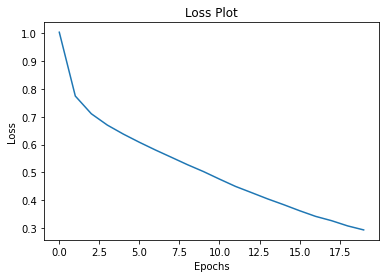

In [14]:
'''Visualize training'''

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [15]:
#Caption
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(tokenizer.index_word[predicted_id])
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [16]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a black and white bird standing on a wooden board <end>
Prediction Caption: a large white bird on a motorbike next to a building <end>


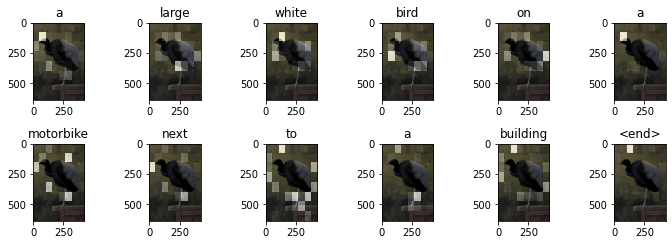

In [17]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [18]:
def evaluate_without_plot(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [19]:
real_captions = []
pred_captions = []

with open('./all_captions.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(["true_caption", "pred_caption"])

    for idx in tqdm(range(len(img_name_val))):
        r_cap = [tokenizer.index_word[i] for i in cap_val[idx] if i not in [0]][1:-1]
        p_cap = evaluate_without_plot(img_name_val[idx])[:-1]
    
        real_captions.append(r_cap)
        pred_captions.append(p_cap)

        writer.writerow([' '.join(r_cap), ' '.join(p_cap)])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
#image_url = '..input/test-image/running-dog-3770607.jpg'
#image_extension = image_url[-4:]
#image_path = tf.keras.utils.get_file('image'+image_extension,
#                                     origin=image_url)

#img,img_path=load_image("..input/test-image/running-dog-3770607.jpg")

# result, attention_plot = evaluate(img)
# print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# # opening the image
# Image.open(image_path)

In [21]:
encoder.save("../working/encoder_model")
decoder.save("../working/decoder_model")

2022-07-12 12:44:08.060677: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
